In [ ]:
!apt install swig
!pip install box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import os
%matplotlib inline

#plt.style.use('seaborn')
plt.style.use('fivethirtyeight')


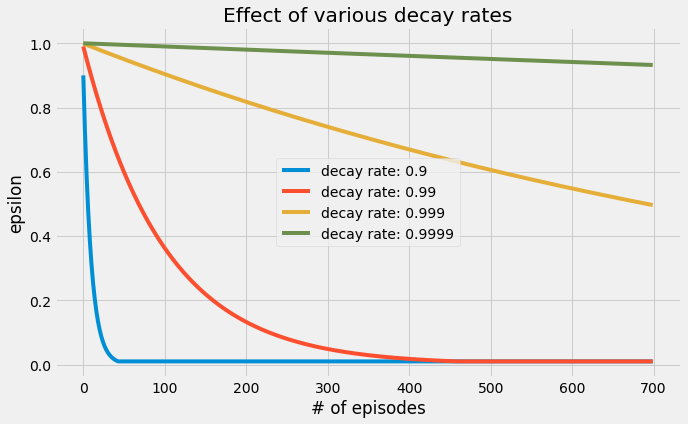

In [ ]:
# Copying the hyperparameters again here, for reference 

BUFFER_SIZE = int(1e5) # Replay memory size
BATCH_SIZE = 32         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
#LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network

MAX_EPISODES = 700 # Max number of episodes to play
MAX_STEPS = 200     # Max steps allowed in a single episode/play
ENV_SOLVED = 200     # MAX score at which we consider environment to be solved
PRINT_EVERY = 100    # How often to print the progress

# Epsilon schedule
EPS_START = 1.0      # Default/starting value of eps
EPS_DECAY = 0.999    # Epsilon decay rate
EPS_MIN = 0.01

#########
EPS_DECAY_RATES = [0.9, 0.99, 0.999, 0.9999]
plt.figure(figsize=(10,6))

for decay_rate in EPS_DECAY_RATES:
    test_eps = EPS_START
    eps_list = []
    for _ in range(MAX_EPISODES):
        test_eps = max(test_eps * decay_rate, EPS_MIN)
        eps_list.append(test_eps)          
    
    plt.plot(eps_list, label='decay rate: {}'.format(decay_rate))

plt.title('Effect of various decay rates')
plt.legend(loc='best')
plt.xlabel('# of episodes')
plt.ylabel('epsilon')
plt.show()

In [ ]:
env = gym.make("CartPole-v0")
print(env)

obs = env.reset()
print("Environment loaded\n")

print(env.observation_space)
print(env.action_space)

<TimeLimit<CartPoleEnv<CartPole-v0>>>
Environment loaded

Box(4,)
Discrete(2)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        """
        Build a fully connected neural network
        
        Parameters
        ----------
        state_size (int): State dimension
        action_size (int): Action dimension
        seed (int): random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64) #Applies a linear transformation to the incoming data
        self.fc2 = nn.Linear(64, 64)

        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, x):
        """Forward pass"""
        x = F.relu(self.fc1(x)) #Applies the rectified linear unit function element-wise
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x               

In [ ]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        """
        Replay memory allow agent to record experiences and learn from them
        
        Parametes
        ---------
        buffer_size (int): maximum size of internal memory
        batch_size (int): sample size from experience
        seed (int): random seed
        """
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)# internal memory (deque)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add experience"""
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
                
    def sample(self):
        """ 
        Sample randomly and return (state, action, reward, next_state, done) tuple as torch tensors 
        """
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)  
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, seed):
        """
        DQN Agent interacts with the environment, 
        stores the experience and learns from it
        
        Parameters
        ----------
        state_size (int): Dimension of state
        action_size (int): Dimension of action
        seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        # Initialize Q and Fixed Q networks
        self.q_network = QNetwork(state_size, action_size, seed).to(device)
        self.fixed_network = QNetwork(state_size, action_size, seed).to(device)
        #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        self.optimizer = optim.Adam(self.q_network.parameters())
        # Initiliase memory 
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.timestep = 0
        
    
    def step(self, state, action, reward, next_state, done):
        """
        Update Agent's knowledge
        
        Parameters
        ----------
        state (array_like): Current state of environment
        action (int): Action taken in current state
        reward (float): Reward received after taking action 
        next_state (array_like): Next state returned by the environment after taking action
        done (bool): whether the episode ended after taking action
        """
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                self.learn(sampled_experiences)
        
    def learn(self, experiences):
        """
        Learn from experience by training the q_network 
        
        Parameters
        ----------
        experiences (array_like): List of experiences sampled from agent's memory
        """
        states, actions, rewards, next_states, dones = experiences
        
        q_values  = self.q_network(states)
        #print('q_values',q_values.shape, len(q_values))

        next_q_values = self.q_network(next_states)
        #print('next_q_values',next_q_values.shape, len(next_q_values))
        next_q_state_values = self.fixed_network(next_states) 
        #print('next_q_state_values',next_q_state_values.shape, len(next_q_state_values))


        q_value  = q_values.gather(1, actions).squeeze(1) 
        #print('q_value',q_value.shape, len(q_value))

        next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
        #print('next_q_value',next_q_value.shape, len(next_q_value))
        
        reward = rewards.squeeze(1)
        done = dones.squeeze(1)
        #print('rewards', reward.shape, len(reward))
        #print('dones', dones.shape, len(dones))
        expected_q_value = reward + GAMMA * next_q_value * (1 - done)
        #print('expected_q_value',expected_q_value.shape, len(expected_q_value))

       
        # Calculate loss
        #loss = F.mse_loss(Q_expected, Q_target)  # I do not undertand?
        #loss = F.mse_loss(Q_target,Q_expected) #Change [Joh+]

        loss = (q_value - (expected_q_value.data)).pow(2).mean()

        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()
        
        # Update fixed weights (ecery cte times update the fixed weights of the target network)
        self.update_fixed_network(self.q_network, self.fixed_network)
        
    def update_fixed_network(self, q_network, fixed_network):
        """
        Update fixed network by copying weights from Q network using TAU param
        
        Parameters
        ----------
        q_network (PyTorch model): Q network
        fixed_network (PyTorch model): Fixed target network
        """
        self.fixed_network.load_state_dict(self.q_network.state_dict())
        
        
    def act(self, state, eps=0.0):
        """
        Choose the action
        Parameters
        ----------
        state (array_like): current state of environment
        eps (float): epsilon for epsilon-greedy action selection
        """
        rnd = random.random()
        if rnd < eps:
            return np.random.randint(self.action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            # set the network into evaluation mode 
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            # Back to training mode
            self.q_network.train()
            action = np.argmax(action_values.cpu().data.numpy())
            return action    
        
    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)

In [ ]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
dqn_agent = DQNAgent(state_size, action_size, seed=0)

In [ ]:
start = time()
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = EPS_START

running_reward = None
running_rewards = []

for episode in range(1, MAX_EPISODES + 1): # from 1 to  MAX_EPISODES + 1, 0 simulation was executed above.
    state = env.reset()
    score = 0
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps) 
        next_state, reward, done, info = env.step(action)   
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward
               
        
        if done: # Break for if the environment is the task is resolved
            break
            
        eps = max(eps * EPS_DECAY, EPS_MIN) #set the exploration/ explotation value for taking an action
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            #dqn_agent.checkpoint(path)
            break
            
    scores_window.append(score) # I am not sure if it has been used.
    scores.append(score)
    running_reward = np.mean(scores[-100:])
    running_rewards.append(running_reward) 
    
end = time()    
print('Took {} seconds'.format(end - start))

 Progress 700/700, average score:199.21Took 122.66235518455505 seconds


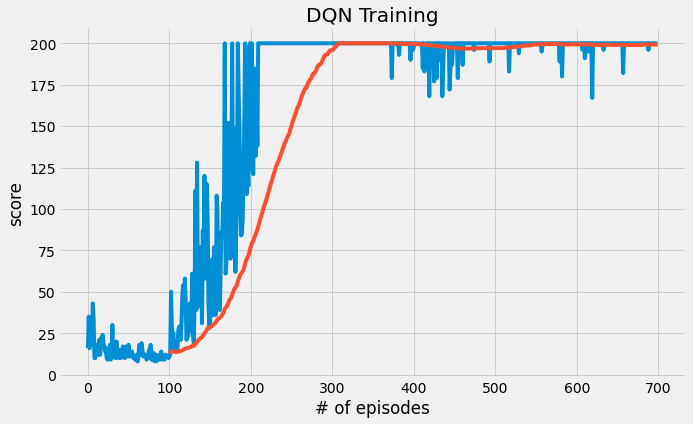

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(scores)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

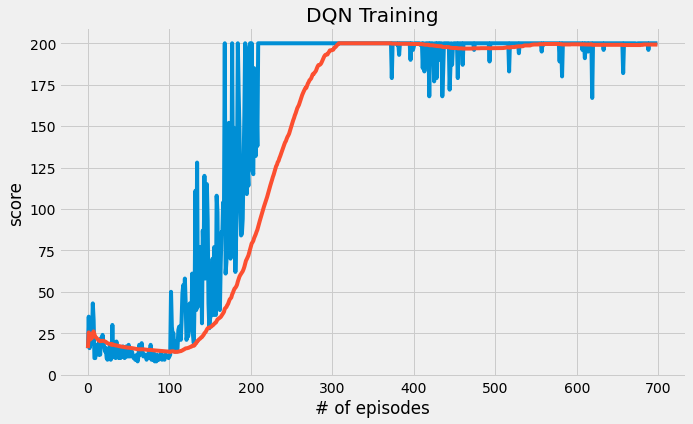

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(scores)
plt.plot(running_rewards)
plt.title('DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

In [ ]:
c = dict()
steps = dict()
# and done being True indicates the episode has terminated. (For example, 
#perhaps the pole tipped too far, or you lost your last life.)
for i in range(1):
    score = 0
    state = env.reset()
    scores = []
    a = 0
    while True:
        action = dqn_agent.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state        
        score += reward
        #print(score)
        scores = np.append(scores,score)
        a= a+1
        if done:
            break
    c[i] = scores
    steps[i] = a

    print('episode: {} scored {}'.format(i, score))

episode: 0 scored 200.0


In [ ]:
env.close()

In [ ]:
https://medium.com/@markelsanz14/introduction-to-reinforcement-learning-part-4-double-dqn-and-dueling-dqn-b349c9a61ea1
https://github.com/dxyang/DQN_pytorch
https://github.com/higgsfield/RL-Adventure/blob/master/2.double%20dqn.ipynb
https://www.datahubbs.com/double-deep-q-learning-to-get-the-most-out-of-your-dqn/
https://www.slideshare.net/ssuserbd7730/pyconkr-2018-rladventureto-the-rainbow

https://medium.com/free-code-camp/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682
18122018_7_Yu-An Wang.pdf
https://www.google.com/search?q=dueling+and+dqn+r&tbm=isch&ved=2ahUKEwjVoPXV28nrAhUvcjABHQQhB0cQ2-cCegQIABAA&oq=dueling+and+dqn+r&gs_lcp=CgNpbWcQA1CnIVi0JWCNKGgAcAB4AIABeIgB7QGSAQMwLjKYAQCgAQGqAQtnd3Mtd2l6LWltZ8ABAQ&sclient=img&ei=iCpPX9W8Dq_kwbkPhMKcuAQ&bih=670&biw=1301&client=ubuntu&hs=wYO#imgrc=1NQ8Sw-dLdXL1M



SyntaxError: ignored